In [7]:
import nupack as npk

from torch.utils.data import DataLoader
from torch import optim
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import pickle

from aptamer_transformer.factories_model_loss import get_model
from aptamer_transformer.data_utils import *
from aptamer_transformer.metric_utils import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
cfg = read_cfg('../aptamer_transformer/config.yaml')
dna_dataset = load_dataset(cfg)
df = load_df(cfg)
# tokenizer = AutoTokenizer.from_pretrained(cfg['tokenizer_path'])

# seqs = tokenizer.batch_decode(dna_dataset.tokenized_seqs, skip_special_tokens=True)
# strand_dict = {i: npk.Strand(seq.replace(' ', ''), name=str(i)) for i, seq in enumerate(seqs)}

In [12]:
strand_dict = {seq: npk.Strand(seq.replace(' ', ''), name=str(i)) for i, seq in enumerate(df.Sequence.values)}

In [ ]:
with open('../data/nupack_strucutre_data/mfe.pickle', 'rb') as f:
    mfe = pickle.load(f)
    
with open('../data/nupack_strucutre_data/proabability_matrix.pickle', 'rb') as f:
    prob = pickle.load(f)

In [98]:
model1 = npk.Model(material='dna', ensemble='stacking', celsius=37, sodium=0.05, magnesium=0.0125)

mfes = {key: npk.mfe([strand_dict[key]], model=model1)  for key in strand_dict}


with open('../data/nupack_strucutre_data/proabability_matrix.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(mfes, f, pickle.HIGHEST_PROTOCOL)



In [ ]:
model1 = npk.Model(material='dna', ensemble='stacking', celsius=37, sodium=0.05, magnesium=0.0125)

probability_matrix  = {key: npk.pairs([strand_dict[key]], model=model1)  for key in strand_dict}


with open('../data/nupack_strucutre_data/some_proabability_matrix.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(probability_matrix, f, pickle.HIGHEST_PROTOCOL)


In [62]:
complexes = {key: npk.Complex([strand_dict[key]]) for key in strand_dict}
strands_for_tube = {value:1e-10 for value in strand_dict.values()}
tubes = {npk.Tube(strands={strand_dict[key]:1e-10}, complexes=npk.SetSpec(max_size=1, include=[npk.Complex([strand_dict[key]])]), name='key') for key in strand_dict}
tube_results = npk.tube_analysis(tubes=[tubes], model=model1, compute=['mfe'])

Physical quantities for complex c
Complex free energy: -1.75 kcal/mol
Partition function: 1.71e+01
MFE proxy structure: .............................((......))..
Free energy of MFE proxy structure: -0.49 kcal/mol


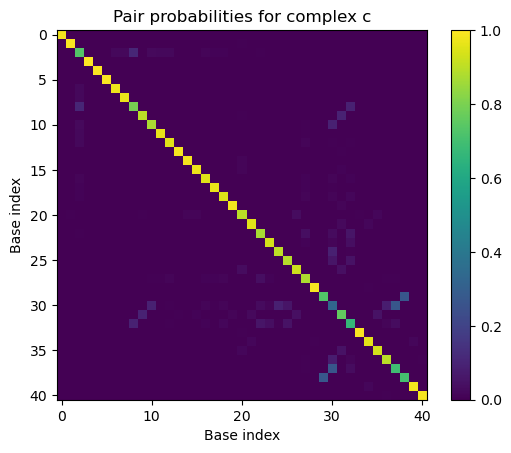

In [88]:
c_result = tube_results[c1] # equivalent to my_result['c']
print('Physical quantities for complex c')
print('Complex free energy: %.2f kcal/mol' % c_result.free_energy)
print('Partition function: %.2e' % c_result.pfunc)
print('MFE proxy structure: %s' % c_result.mfe[0].structure)
print('Free energy of MFE proxy structure: %.2f kcal/mol' % c_result.mfe[0].energy)
plt.imshow(tube_results[c1].pairs.to_array())
plt.xlabel('Base index')
plt.ylabel('Base index')
plt.title('Pair probabilities for complex c')
plt.colorbar()
plt.clim(0, 1)
# plt.savefig('my-figure.pdf') # optionally, save a PDF of your figure

In [51]:
sampled_structures = npk.sample(strands=[strand_dict[0]], model=model1, num_sample=10)
sampled_structures

[Structure('.........................(....)..........'),
 Structure('..(...)......................((......))..'),
 Structure('....................(.....)..............'),
 Structure('......................(....).((......))..'),
 Structure('..(.....).....................(......)...'),
 Structure('.........................((....))........'),
 Structure('.........................((....))........'),
 Structure('..(.........)................((......))..'),
 Structure('......................(.......((...))...)'),
 Structure('.............................((......))..')]

In [60]:
mfe_structures = npk.mfe(strands=[strand_dict[0]], model=model1)
print('Free energy of MFE proxy structure: %.2f kcal/mol' % mfe_structures[0].energy)
print('MFE proxy structure in dot-parens-plus notation: %s' % mfe_structures[0].structure)
print('MFE proxy structure as structure matrix:\n%s' % mfe_structures[0].structure.matrix())

Free energy of MFE proxy structure: -0.49 kcal/mol
MFE proxy structure in dot-parens-plus notation: .............................((......))..
MFE proxy structure as structure matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
